In [75]:
#https://www.kaggle.com/code/ryanholbrook/mutual-information

**Introduction**
First encountering a new dataset can sometimes feel overwhelming. You might be presented with hundreds or thousands of features without even a description to go by. Where do you even begin?

A great first step is to construct a ranking with a feature utility metric, a function measuring associations between a feature and the target. Then you can choose a smaller set of the most useful features to develop initially and have more confidence that your time will be well spent.

The metric we'll use is called "mutual information". Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:

easy to use and interpret,
computationally efficient,
theoretically well-founded,
resistant to overfitting, and,
able to detect any kind of relationship
Mutual Information and What it Measures
Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Here's an example from the Ames Housing data. The figure shows the relationship between the exterior quality of a house and the price it sold for. Each point represents a house.

(Technical note: **What we're calling uncertainty is measured using a quantity from information theory known as "entropy".** The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average." The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the target.)

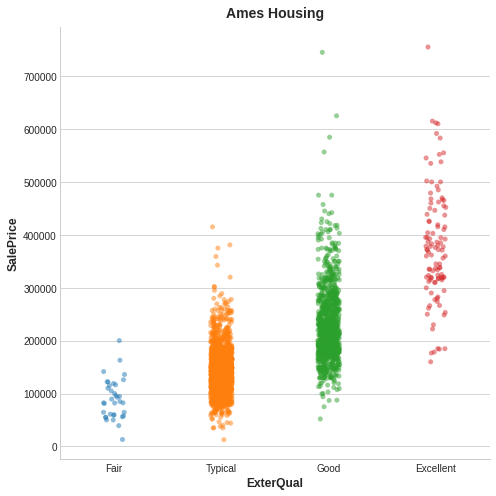

From the figure, we can see that knowing the value of ExterQual should make you more certain about the corresponding SalePrice -- each category of ExterQual tends to concentrate SalePrice to within a certain range. The mutual information that ExterQual has with SalePrice is the average reduction of uncertainty in SalePrice taken over the four values of ExterQual. Since Fair occurs less often than Typical, for instance, Fair gets less weight in the MI score.

**Here are some things to remember when applying mutual information:**

MI can help you to understand the relative potential of a feature as a predictor of the target, considered by itself.
It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

#plt.style.use("seaborn-whitegrid")
data = pd.read_csv('autos.csv')

data.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


In [116]:
data.index, data.describe()

(RangeIndex(start=0, stop=193, step=1),
         symboling  num_of_doors  wheel_base      length       width  \
 count  193.000000    193.000000  193.000000  193.000000  193.000000   
 mean     0.797927      3.160622   98.923834  174.326425   65.893782   
 std      1.235582      0.989583    6.152409   12.478593    2.137795   
 min     -2.000000      2.000000   86.600000  141.100000   60.300000   
 25%      0.000000      2.000000   94.500000  166.300000   64.100000   
 50%      1.000000      4.000000   97.000000  173.200000   65.400000   
 75%      2.000000      4.000000  102.400000  184.600000   66.900000   
 max      3.000000      4.000000  120.900000  208.100000   72.000000   
 
            height  curb_weight  num_of_cylinders  engine_size        bore  \
 count  193.000000   193.000000        193.000000   193.000000  193.000000   
 mean    53.869948  2561.507772          4.419689   128.124352    3.330622   
 std      2.394770   526.700026          1.023182    41.590452    0.272385  

In [106]:
X = data.copy()
y = X.pop('price')

len(X.columns)

24

In [107]:
#filter
categorical_columns = [colm for colm in X.columns if X[colm].dtype == 'object']
numerical_columns = [colm for colm in X.columns if X[colm].dtype in ['int64', 'float64'] ]

In [79]:
X[categorical_columns]

,make,fuel_type,aspiration,body_style,drive_wheels,engine_location,engine_type,fuel_system
0,alfa-romero,gas,std,convertible,rwd,front,dohc,mpfi
1,alfa-romero,gas,std,convertible,rwd,front,dohc,mpfi
2,alfa-romero,gas,std,hatchback,rwd,front,ohcv,mpfi
3,audi,gas,std,sedan,fwd,front,ohc,mpfi
4,audi,gas,std,sedan,4wd,front,ohc,mpfi
...,...,...,...,...,...,...,...,...
188,volvo,gas,std,sedan,rwd,front,ohc,mpfi
189,volvo,gas,turbo,sedan,rwd,front,ohc,mpfi
190,volvo,gas,std,sedan,rwd,front,ohcv,mpfi
191,volvo,diesel,turbo,sedan,rwd,front,ohc,idi


In [80]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

for col in categorical_columns:
    X[col] = label_encoder.fit_transform(X[col])

In [81]:
discrete_features = X[categorical_columns]

Scikit-learn has two mutual information metrics in its feature_selection module: one for real-valued targets (mutual_info_regression) and one for categorical targets (mutual_info_classif). Our target, price, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [88]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X,y, categorical_columns):
    mi_scores = mutual_info_regression(X,y, discrete_features= discrete_features)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


mi_scores = make_mi_scores(X,y, discrete_features)

print(mi_scores[::3])
print(mi_scores.index)
print(len(mi_scores))

curb_weight          1.500666
wheel_base           1.053946
highway_mpg          0.884666
bore                 0.695156
fuel_system          0.484343
symboling            0.229976
compression_ratio    0.133841
fuel_type            0.047279
Name: MI Scores, dtype: float64
Index(['curb_weight', 'horsepower', 'length', 'wheel_base', 'engine_size',
       'width', 'highway_mpg', 'city_mpg', 'stroke', 'bore', 'height', 'make',
       'fuel_system', 'drive_wheels', 'num_of_cylinders', 'symboling',
       'peak_rpm', 'engine_type', 'compression_ratio', 'aspiration',
       'body_style', 'fuel_type', 'engine_location', 'num_of_doors'],
      dtype='object')
24


And now a bar plot to make comparisions easier:

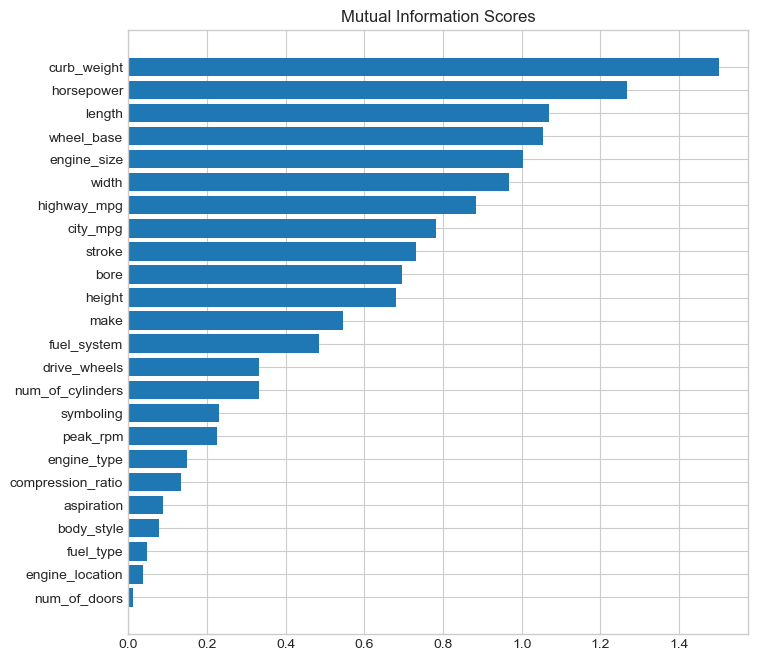

In [95]:
def plot_mi_score(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
    
plt.figure(dpi=100, figsize=(8,8))
plot_mi_score(mi_scores)    

Data visualization is a great follow-up to a utility ranking. Let's take a closer look at a couple of these.

As we might expect, the high-scoring curb_weight feature exhibits a strong relationship with price, the target.

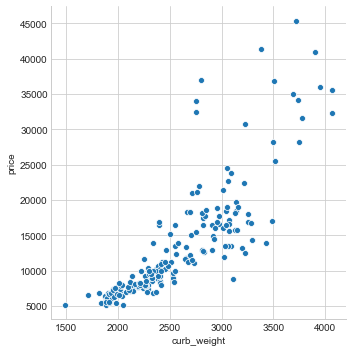

In [100]:
sns.relplot(x="curb_weight", y="price", data=data);

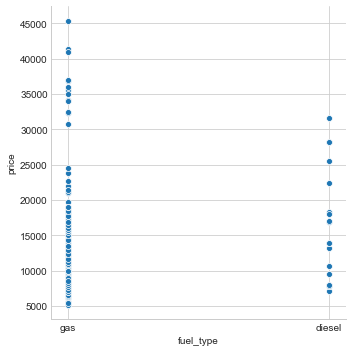

In [101]:
sns.relplot(x="fuel_type", y="price", data=data);

The fuel_type feature has a fairly low MI score, but as we can see from the figure, it clearly separates two price populations with different trends within the horsepower feature. This indicates that fuel_type contributes an interaction effect and might not be unimportant after all. Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance here.

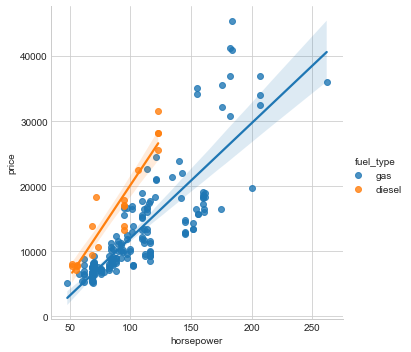

In [103]:
sns.lmplot(x='horsepower', y = 'price', hue = 'fuel_type', data = data)
plt.show()